In [7]:
from finta import TA

import pandas as pd
import yfinance as yf
import pandas as pd
from datetime import datetime
from meteostat import Point, Daily
from functools import reduce

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10



from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor


import warnings
warnings.filterwarnings('once')



In [8]:
data = pd.read_csv('data/sp500_stocks.csv')

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
#sort by Date
data.sort_values(by='Date', inplace=True)
#add 25 and 50 rolling avergaed of close by Symbol
data['25ma'] = data.groupby('Symbol')['Close'].shift().rolling(window=25).mean()
data['50ma'] = data.groupby('Symbol')['Close'].shift().rolling(window=50).mean()
data['100ma'] = data.groupby('Symbol')['Close'].shift().rolling(window=100).mean()  
data['200ma'] = data.groupby('Symbol')['Close'].shift().rolling(window=200).mean()


#drop rows with NaN

data.tail()

#set frequency to daily




,Symbol,Adj Close,Close,High,Low,Open,Volume,25ma,50ma,100ma,200ma
Date,,,,,,,,,,,
2024-03-18,LW,102.860001,102.860001,103.570000,100.559998,101.599998,1242540.0,206.190803,180.387401,170.649901,186.52080
2024-03-18,GD,277.600006,277.600006,277.720001,274.670013,275.989990,850451.0,214.685203,183.910201,173.198601,187.49295
2024-03-18,HAS,53.290001,53.290001,53.466000,52.959999,53.250000,1173531.0,206.531603,181.980401,173.388401,185.99835
2024-03-18,CTVA,54.709999,54.709999,55.450001,54.520000,55.450001,2943730.0,193.399603,180.014801,172.464501,185.94265
2024-03-18,ZTS,170.690002,170.690002,174.279999,170.410004,173.740005,4919422.0,194.271603,180.708202,172.912901,186.22535


In [9]:


# Assuming 'data' is your DataFrame
# Ensure your DataFrame is sorted by 'Date' if it's not already
data.sort_values(by=['Date'], inplace=True)

# Placeholder DataFrame to hold the results
result_data = pd.DataFrame()

for symbol in data['Symbol'].unique():
    # Filter the DataFrame for the current symbol
    stock_data = data[data['Symbol'] == symbol]
    
    # Calculate the SMA for the filtered DataFrame
    # Here, we are calculating a 20-day SMA of the 'Close' price
    stock_data['RSI'] = TA.RSI(stock_data)
    stock_data['ATR'] = TA.ATR(stock_data)
    stock_data['BBWIDTH'] = TA.BBWIDTH(stock_data)
    stock_data['WilliamsR'] = TA.WILLIAMS(stock_data)
    
    # Append the results to the result_data
    result_data = pd.concat([result_data, stock_data])

# Optionally, you might want to sort the result_data by 'Date' and 'Symbol' again
result_data.sort_values(by=['Date', 'Symbol'], inplace=True)

data = result_data
# result_data now contains your original data along with the new 20d_SMA indicator for each stock


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [10]:
def fetch_weather_data(city_points, start_date, end_date):
    weather_frames = []
    for city_name, point in city_points.items():
        weather = Daily(point, start_date, end_date).fetch().reset_index()
        weather.rename(columns={'time': 'Date', 'tavg': f'tavg_{city_name}'}, inplace=True)
        weather = weather[['Date', f'tavg_{city_name}']]
        weather_frames.append(weather)
    return reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), weather_frames)

# Define cities for weather data
cities = {
    'NewYork': Point(40.7128, -74.0060),   # New York City, USA
    'London': Point(51.5074, -0.1278),      # London, UK
    'Paris': Point(48.8566, 2.3522),        # Paris, France
    'Tokyo': Point(35.6895, 139.6917),      # Tokyo, Japan
    'Sydney': Point(-33.8688, 151.2093),     # Sydney, Australia
    'Berlin': Point(52.5200, 13.4050),       # Berlin, Germany


}

weather_data = fetch_weather_data(cities, min(data.index), max(data.index))

weather_data.head()


,Date,tavg_NewYork,tavg_London,tavg_Paris,tavg_Tokyo,tavg_Sydney,tavg_Berlin
0,2010-01-04,-4.6,-0.3,-3.6,6.6,22.2,-5.6
1,2010-01-05,-3.3,1.0,-2.2,7.4,24.1,-5.3
2,2010-01-06,-0.9,1.1,-2.7,6.2,22.0,-6.4
3,2010-01-07,1.0,-1.1,-2.8,7.9,22.4,-5.1
4,2010-01-08,-1.4,-0.2,-3.9,7.3,24.1,-4.5


In [11]:
merged_data = pd.merge(data, weather_data, on='Date', how='left')
merged_data.head()

#print nan per column
print(merged_data.isnull().sum())

#to csv 
merged_data.to_csv('data/merged_data.csv')

data = merged_data  

Date                  0
Symbol                0
Adj Close         79913
Close             79913
High              79913
Low               79913
Open              79913
Volume            79913
25ma             985810
50ma            1265771
100ma           1484253
200ma           1637290
RSI               80439
ATR               86452
BBWIDTH           89470
WilliamsR         86897
tavg_NewYork          0
tavg_London           0
tavg_Paris            0
tavg_Tokyo            0
tavg_Sydney           0
tavg_Berlin           0
dtype: int64


In [12]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
data.dropna(subset=['Close', '25ma', '50ma', '100ma', '200ma', 'tavg_NewYork', 'tavg_London', 'tavg_Paris', 'tavg_Tokyo', 'tavg_Sydney', 'tavg_Berlin', 'RSI', 'ATR', 'BBWIDTH', 'WilliamsR'], inplace=True)
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
print(len(data))
print(data.info())

Number of rows with missing values: 0.9105289938689541
Number of rows with missing values: 0.0
Number of rows with missing values: 0.0
160889
<class 'pandas.core.frame.DataFrame'>
Index: 160889 entries, 816874 to 1798224
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          160889 non-null  datetime64[ns]
 1   Symbol        160889 non-null  object        
 2   Adj Close     160889 non-null  float64       
 3   Close         160889 non-null  float64       
 4   High          160889 non-null  float64       
 5   Low           160889 non-null  float64       
 6   Open          160889 non-null  float64       
 7   Volume        160889 non-null  float64       
 8   25ma          160889 non-null  float64       
 9   50ma          160889 non-null  float64       
 10  100ma         160889 non-null  float64       
 11  200ma         160889 non-null  float64       
 12  RSI           160889 non-nu

Train error: 46.85772347270862
Test error: 74.47271418208628


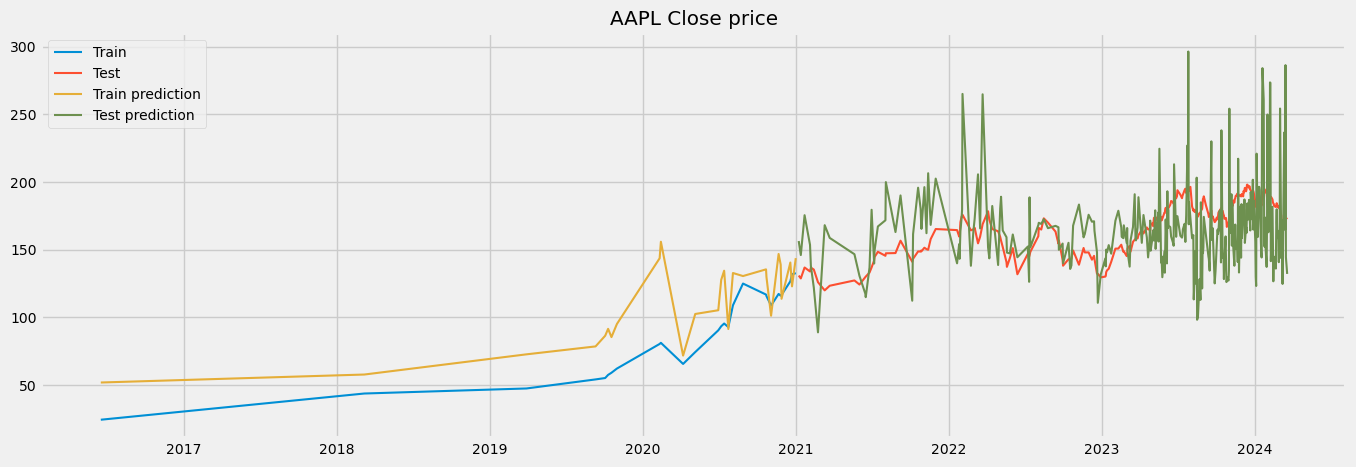

In [13]:
#forcast the close price using the 25ma and 50ma
#train the model_Ridge
#convert Date to index
data.set_index('Date', inplace=True)

data_train = data.loc[data.index < '2021-01-01']
data_test = data.loc[data.index >= '2021-01-01']

X_train = data_train[['25ma', '50ma', '100ma', '200ma', 'tavg_NewYork', 'tavg_London', 'tavg_Paris', 'tavg_Tokyo', 'tavg_Sydney', 'tavg_Berlin', 'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_train = data_train['Close']

X_test = data_test[['25ma', '50ma', '100ma', '200ma', 'tavg_NewYork', 'tavg_London', 'tavg_Paris', 'tavg_Tokyo', 'tavg_Sydney', 'tavg_Berlin', 'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model_Ridge = Ridge()
model_Ridge.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results
plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()


# SGQRegressor

Train error: 58.89831152215526
Test error: 98.7214108302544


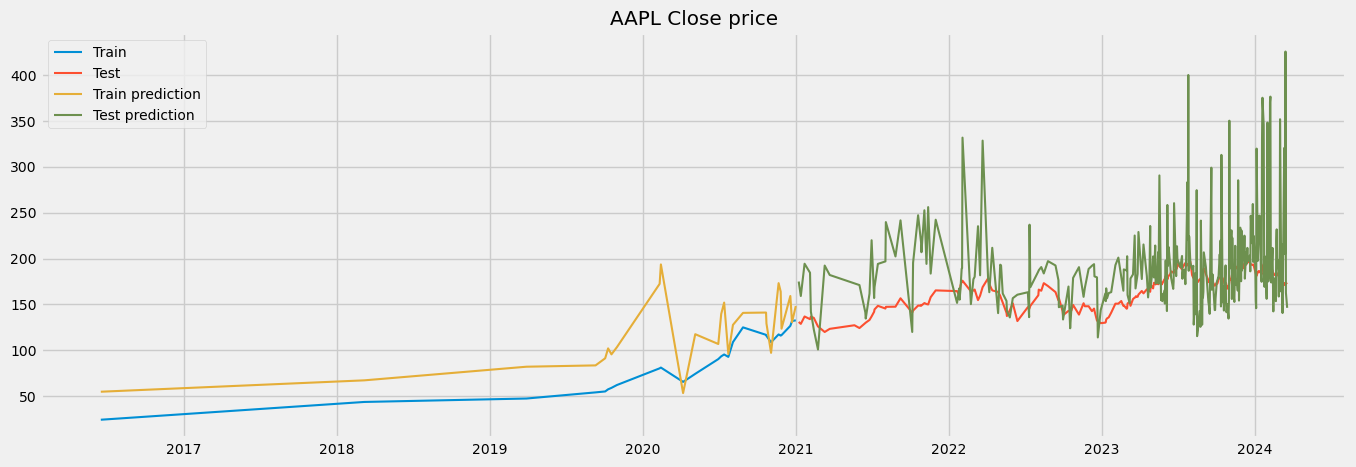

In [14]:
#forcast the close price using the 25ma and 50ma
#train the model_Ridge
data_train = data.loc[data.index < '2021-01-01']
data_test = data.loc[data.index >= '2021-01-01']

X_train = data_train[['25ma', '50ma', '100ma', '200ma', 'tavg_NewYork', 'tavg_London', 'tavg_Paris', 'tavg_Tokyo', 'tavg_Sydney', 'tavg_Berlin', 'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_train = data_train['Close']

X_test = data_test[['25ma', '50ma', '100ma', '200ma', 'tavg_NewYork', 'tavg_London', 'tavg_Paris', 'tavg_Tokyo', 'tavg_Sydney', 'tavg_Berlin', 'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model_Ridge = SGDRegressor()
model_Ridge.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results
plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()


Train error: 7.608220946724695
Test error: 38.29052672990633


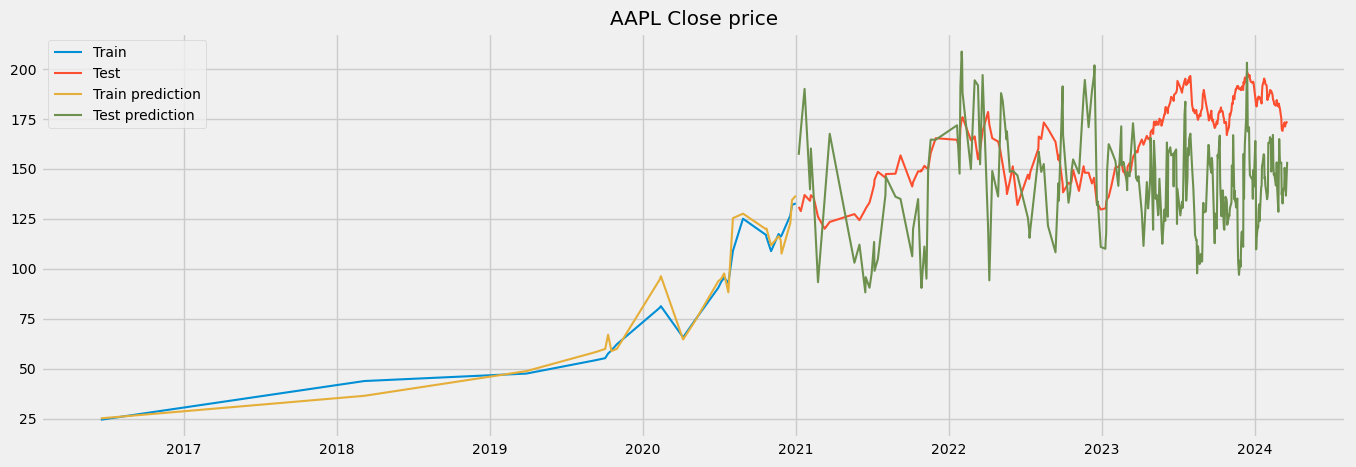

In [15]:
#forcast the close price using the 25ma and 50ma
#train the model_Ridge
data_train = data.loc[data.index < '2021-01-01']
data_test = data.loc[data.index >= '2021-01-01']

X_train = data_train[['25ma', '50ma', '100ma', '200ma', 'tavg_NewYork', 'tavg_London', 'tavg_Paris', 'tavg_Tokyo', 'tavg_Sydney', 'tavg_Berlin', 'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_train = data_train['Close']

X_test = data_test[['25ma', '50ma', '100ma', '200ma', 'tavg_NewYork', 'tavg_London', 'tavg_Paris', 'tavg_Tokyo', 'tavg_Sydney', 'tavg_Berlin', 'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model_Ridge = RandomForestRegressor(n_estimators=1000)
model_Ridge.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results
plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()


#XGBOOSt

Train error: 7.608220946724695
Test error: 38.29052672990633


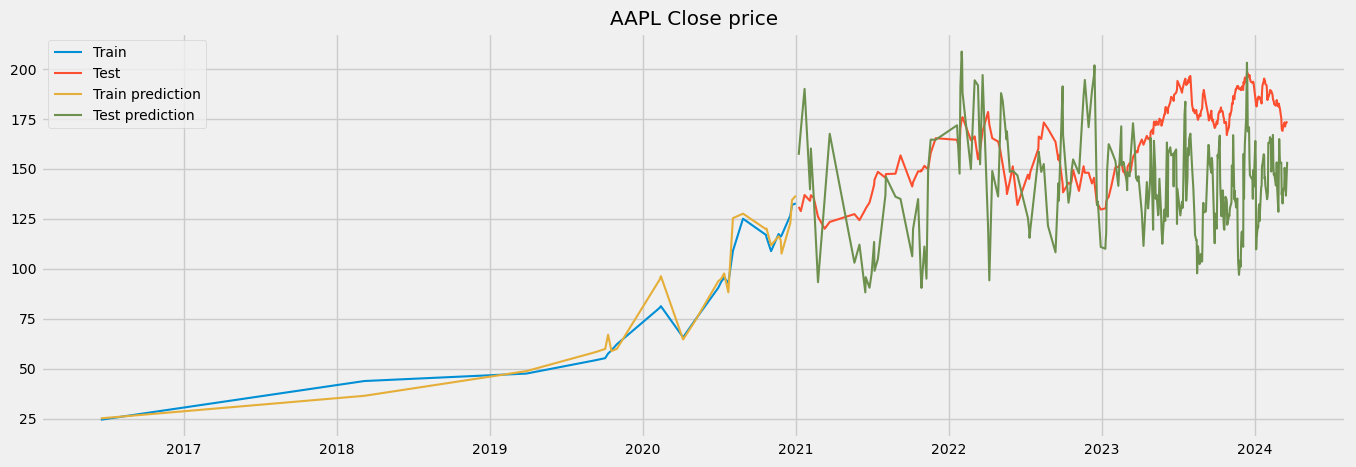

In [16]:
data_train = data.loc[data.index < '2021-01-01']
data_test = data.loc[data.index >= '2021-01-01']

X_train = data_train[['25ma', '50ma', '100ma', '200ma', 'tavg_NewYork', 'tavg_London', 'tavg_Paris', 'tavg_Tokyo', 'tavg_Sydney', 'tavg_Berlin', 'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_train = data_train['Close']

X_test = data_test[['25ma', '50ma', '100ma', '200ma', 'tavg_NewYork', 'tavg_London', 'tavg_Paris', 'tavg_Tokyo', 'tavg_Sydney', 'tavg_Berlin', 'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model = XGBRegressor(n_estimators=1000)
model.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results

plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()
plt.show()
